In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 1 — Introduction to Machine Learning
## Lesson 12: Reproducibility Basics (Random Seeds, Determinism, Experiment Tracking Concepts)

This notebook is part of the **Introductory Course of Machine Learning**.

**Repository conventions assumed**
- Datasets live under `Datasets/...`
- Notebooks live under `Tutorials/English/...` and `Tutorials/Persian/...`
- CSS files live under `css/` and are applied at the top of each notebook

> Important: In markdown, this course uses inline math as `$ ... $` and display math as `$$ ... $$`.



### Learning objectives

By the end of this lesson, you will be able to:

1. Explain what *reproducibility* means in machine learning and why it is necessary for credible results.
2. Control randomness using **random seeds** in Python, NumPy, and scikit-learn (and understand the limits of seeds).
3. Distinguish *reproducibility* from *determinism* (and recognize common sources of non-determinism).
4. Implement a minimal **experiment tracking** pattern: log parameters, metrics, and artifacts in a structured way.
5. Apply a practical reproducibility checklist to your own projects.

### Why this matters

Machine learning results are *procedural*: they depend on data, preprocessing, training, evaluation, and the computing environment.  
If you cannot reproduce a result, you cannot reliably debug it, compare it, publish it, or deploy it.

A useful mental model is:

- You run a **pipeline** $f(\text{data}, \text{code}, \text{randomness}, \text{environment}) \to (\text{metrics}, \text{model})$.
- Reproducibility means: you can run the same pipeline again and obtain the same (or acceptably close) outputs.



## 1. Reproducibility vs determinism

These terms are related but not identical.

### Reproducibility (practical)

A result is *reproducible* if you can rerun your process and obtain the same conclusion.  
Often the conclusion is not “bitwise identical weights” but “the same metrics within tolerance” and “the same model selection decision”.

### Determinism (technical)

A computation is *deterministic* if, for a fixed input, it produces **exactly** the same output every time.

In ML practice:
- You can often make **data splits** and **model training** *repeatable* using seeds.
- You cannot always guarantee **bitwise determinism** due to floating-point behavior, parallelism, library implementations, and hardware.

### A practical hierarchy

1. **Repeatable splits and preprocessing** (seeded shuffling, fixed feature engineering).
2. **Repeatable training** (controlled initialization, controlled stochasticity).
3. **Repeatable evaluation** (fixed test set, fixed thresholding, fixed scoring).
4. **Traceability** (log what you did so you can explain and re-run it later).



## 2. Random seeds: controlling randomness on purpose

Many ML procedures involve randomness:
- train/test splits with shuffling
- random initialization (e.g., k-means centroids)
- stochastic optimization (e.g., SGD)
- random feature subsampling (e.g., Random Forest)

A **seed** initializes a pseudo-random number generator (PRNG). With a fixed seed, PRNG outputs repeat.

### Key principle

Seeds only help if:
- the algorithm actually uses the PRNG you seeded, and
- nothing else introduces non-determinism (parallelism, non-associative reductions, etc.).

### PRNGs you should know

- Python standard library: `random`
- NumPy: `np.random` (legacy global) and `np.random.default_rng()` (recommended)
- scikit-learn: uses `random_state=` in many estimators and utilities



## 3. Common sources of non-determinism (even with seeds)

Even with fixed seeds, you can still see run-to-run differences. Common causes:

1. **Floating-point non-associativity**  
   Because of rounding, $(a+b)+c$ can differ from $a+(b+c)$.
2. **Parallel execution** (BLAS/OpenMP/MKL)  
   The order of reductions can vary between threads.
3. **Hash randomization** in Python  
   Dictionary/set iteration ordering can change unless controlled.
4. **Library / compiler / hardware differences**  
   Different versions of NumPy, scikit-learn, BLAS, or CPU features can alter numerics.
5. **Data changes**  
   If the dataset file changes, seeds cannot recover the old result.

Practical takeaway: aim for **repeatability and traceability**, not perfection.



## 4. Experiment tracking (concepts)

Experiment tracking means you can answer, later:

- What data did I use?
- What code and parameters did I run?
- What metrics did I obtain?
- Where is the trained model artifact (if any)?

Even without specialized tools, you can track experiments by logging:

- **parameters** (e.g., `random_state`, model hyperparameters)
- **metrics** (accuracy, RMSE, etc.)
- **artifacts** (plots, trained model file, feature list, dataset hash)
- **environment** (Python version, library versions)

Specialized tools (MLflow, Weights & Biases, Neptune) automate this.  
But the underlying discipline is the same.



## 5. Hands-on: reproducibility patterns in code

In this section you will see three kinds of practical examples:

1. **Pure PRNG reproducibility** (NumPy seeding, and a visual check with a histogram).
2. **Model reproducibility** (controlled train/test splitting and consistent metrics).
3. **Data + pipeline robustness** (cleaning “messy” columns and fixing common reproducibility bugs).

### 5.1 Seeded randomness in NumPy

If you set the same seed before drawing random numbers, you should get the same sequence.

A strong habit is to use a *local* generator (`default_rng`) and pass it around.


In [2]:
import numpy as np

# Example: same seed -> same pseudo-random numbers
np.random.seed(123)
x1 = np.random.normal(loc=0.0, scale=1.0, size=8)

np.random.seed(123)
x2 = np.random.normal(loc=0.0, scale=1.0, size=8)

print("x1 =", x1)
print("x2 =", x2)
print("All close?", np.allclose(x1, x2))

x1 = [-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263]
x2 = [-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263]
All close? True


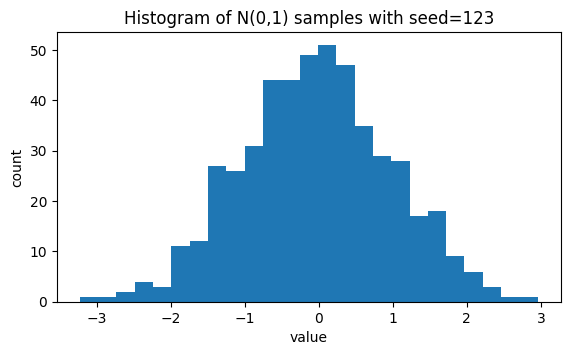

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
sample = np.random.normal(size=500)

plt.figure(figsize=(6.5, 3.5))
plt.hist(sample, bins=25)
plt.title("Histogram of N(0,1) samples with seed=123")
plt.xlabel("value")
plt.ylabel("count")
plt.show()


### 5.2 Preferred RNG pattern

Instead of relying on global state (`np.random.seed`), use a `Generator` object.

This makes it easier to:
- isolate randomness to a specific experiment,
- avoid accidental interference from other code,
- record and replay streams of randomness.


In [4]:
import numpy as np

# Recommended modern pattern: use your own Generator (avoid global state)
rng = np.random.default_rng(2026)

print("Uniform(0,1):", rng.random(5))
print("Integers:", rng.integers(low=0, high=10, size=8))

# If you pass rng around, your pipeline becomes easier to reproduce.

Uniform(0,1): [0.17893481 0.63991317 0.4672684  0.37050053 0.35491733]
Integers: [8 7 7 9 7 1 8 6]



### 5.3 Loading datasets with stable relative paths

In this repository, datasets are read via relative paths like:

`../../../Datasets/Classification/iris.csv`

To make this notebook runnable *outside* the repo (e.g., in a standalone environment), the code below uses a fallback sample if the file is missing.  
In your actual repo, the file should exist and the notebook will use it automatically.


In [5]:
from pathlib import Path
import pandas as pd
from io import StringIO

path = Path("../../../Datasets/Classification/iris.csv")

if path.exists():
    iris = pd.read_csv(path)
else:
    iris = pd.read_csv(StringIO("""sepal_length,sepal_width,petal_length,petal_width,classification
5.4,3.7,1.5,0.2,Iris-setosa
4.8,3.4,1.6,0.2,Iris-setosa
4.8,3,1.4,0.1,Iris-setosa
4.3,3,1.1,0.1,Iris-setosa
5.8,4,1.2,0.2,Iris-setosa
"""))

print("Shape:", iris.shape)
print(iris.head().to_string(index=False))

Shape: (150, 5)
 sepal_length  sepal_width  petal_length  petal_width classification
          5.4          3.7           1.5          0.2    Iris-setosa
          4.8          3.4           1.6          0.2    Iris-setosa
          4.8          3.0           1.4          0.1    Iris-setosa
          4.3          3.0           1.1          0.1    Iris-setosa
          5.8          4.0           1.2          0.2    Iris-setosa



### 5.4 Reproducible train/test splits and model training

A common reproducibility bug is forgetting to set `random_state` in:

- `train_test_split(..., random_state=...)`
- models that randomize internally (e.g., tree ensembles, k-means, stochastic solvers)

Below, we train the same pipeline multiple times with different seeds. You should observe:

- different seeds can yield different accuracies,
- repeating the same seed yields the same accuracy.


In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

X, y = make_classification(
    n_samples=500, n_features=8, n_informative=5, n_redundant=1,
    n_classes=2, flip_y=0.02, class_sep=1.2, random_state=7
)

def run(seed):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
    ])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    return accuracy_score(yte, pred)

acc0 = run(0)
acc1 = run(1)
acc0_again = run(0)

print(f"Accuracy with seed=0: {acc0:.3f}")
print(f"Accuracy with seed=1: {acc1:.3f}")
print(f"Accuracy with seed=0 (repeat): {acc0_again:.3f}")

Accuracy with seed=0: 0.800
Accuracy with seed=1: 0.792
Accuracy with seed=0 (repeat): 0.800



#### Detailed evaluation

For a fixed seed (here: `random_state=0`) we can also print a classification report.


In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X, y = make_classification(
    n_samples=500, n_features=8, n_informative=5, n_redundant=1,
    n_classes=2, flip_y=0.02, class_sep=1.2, random_state=7
)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, solver="lbfgs"))
])

pipe.fit(Xtr, ytr)
pred = pipe.predict(Xte)

print(classification_report(yte, pred, digits=3))

              precision    recall  f1-score   support

           0      0.817     0.778     0.797        63
           1      0.785     0.823     0.803        62

    accuracy                          0.800       125
   macro avg      0.801     0.800     0.800       125
weighted avg      0.801     0.800     0.800       125




### 5.5 Reproducibility meets data hygiene: fixing messy columns (hw_200.csv)

A “non-reproducibility” issue is often just a **data schema** issue.  
For example, your code might expect a column called `"Height(Inches)"`, but the CSV header may contain extra quotes or spaces.

In this repository, `hw_200.csv` has a header that can produce surprising column names.  
If you see errors like `KeyError: "Height(Inches)"`, you should inspect and normalize the columns.

Below:
1. we load the file (or a fallback sample),
2. normalize column names,
3. convert columns to numeric,
4. run k-means with a fixed `random_state`.


In [8]:
from pathlib import Path
import pandas as pd
from io import StringIO

path = Path("../../../Datasets/Clustering/hw_200.csv")

if path.exists():
    hw = pd.read_csv(path)
else:
    hw = pd.read_csv(StringIO('''"Index", Height(Inches)", "Weight(Pounds)"
1, 65.78, 112.99
2, 71.52, 136.49
3, 69.40, 153.03
4, 68.22, 142.34
5, 67.79, 144.30
6, 68.70, 123.30
'''), engine="python", skipinitialspace=True)

# Normalize column names (remove quotes/spaces)
hw.columns = [c.strip().strip('"').strip() for c in hw.columns]
hw = hw.rename(columns={c: c.replace('Height(Inches)"', 'Height(Inches)') for c in hw.columns})

# Convert numeric columns safely
for c in hw.columns:
    hw[c] = pd.to_numeric(hw[c], errors="coerce")

print("Columns:", list(hw.columns))
print(hw.head().to_string(index=False))

Columns: ['Index', 'Height(Inches)', 'Weight(Pounds)']
 Index  Height(Inches)  Weight(Pounds)
     1           65.78          112.99
     2           71.52          136.49
     3           69.40          153.03
     4           68.22          142.34
     5           67.79          144.30


In [9]:
import numpy as np
from sklearn.cluster import KMeans

X_hw = hw[["Height(Inches)", "Weight(Pounds)"]].values.astype(float)

km = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = km.fit_predict(X_hw)

print("Cluster centers (random_state=42):")
print(km.cluster_centers_)
print("Inertia:", km.inertia_)
print("Label counts:", dict(zip(*np.unique(labels, return_counts=True))))

Cluster centers (random_state=42):
[[ 68.75776786 135.68151786]
 [ 66.92147727 116.45522727]]
Inertia: 10836.546087337665
Label counts: {np.int32(0): np.int64(112), np.int32(1): np.int64(88)}



#### Changing the seed changes the outcome

k-means uses random initialization (unless you fully control initialization).  
Changing `random_state` can change the solution, especially when there are multiple local minima.

This is not a bug: it is a property of the algorithm.  
For reproducible reporting, always record the seed and consider running multiple initializations.


In [10]:
import numpy as np
from sklearn.cluster import KMeans

X_hw = hw[["Height(Inches)", "Weight(Pounds)"]].values.astype(float)

km1 = KMeans(n_clusters=2, random_state=42, n_init=10)
lab1 = km1.fit_predict(X_hw)

km2 = KMeans(n_clusters=2, random_state=1, n_init=10)
lab2 = km2.fit_predict(X_hw)

print("Centers with random_state=42:")
print(km1.cluster_centers_)
print("Centers with random_state=1:")
print(km2.cluster_centers_)

Centers with random_state=42:
[[ 68.75776786 135.68151786]
 [ 66.92147727 116.45522727]]
Centers with random_state=1:
[[ 68.75776786 135.68151786]
 [ 66.92147727 116.45522727]]



## 6. Determinism in practice: floating point and parallelism

Even if you set every seed, you can still see small numerical differences.  
One fundamental reason is that floating-point addition is not associative:

$$
(a+b)+c \neq a+(b+c)
$$

The example below is a classic demonstration using very large and very small numbers.


In [11]:
# Floating-point non-associativity demo
a, b, c = 1e16, -1e16, 1.0

left = (a + b) + c
right = a + (b + c)

print("(a + b) + c =", left)
print("a + (b + c) =", right)
print("Equal?", left == right)

(a + b) + c = 1.0
a + (b + c) = 0.0
Equal? False



### 6.1 Controlling threads (best effort)

On CPU, many numerical libraries use multi-threading. Different thread schedules can change the order of operations and produce slightly different floats.

If you need maximal repeatability, you can set (for example) `OMP_NUM_THREADS=1` and `MKL_NUM_THREADS=1` before starting Python.

The cell below prints these environment variables so you can confirm your configuration.


In [12]:
import os, sys
import numpy as np

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)

# Thread control (best effort). For strict control, set these *before* importing NumPy in a fresh process.
for k in ["OMP_NUM_THREADS", "MKL_NUM_THREADS", "OPENBLAS_NUM_THREADS", "NUMEXPR_NUM_THREADS"]:
    print(f"{k} =", os.environ.get(k))

print("\nTip: For maximum repeatability on CPU, you can set these env vars to 1 and rerun the notebook kernel.")

Python: 3.13.0
NumPy: 2.1.2
OMP_NUM_THREADS = None
MKL_NUM_THREADS = None
OPENBLAS_NUM_THREADS = None
NUMEXPR_NUM_THREADS = None

Tip: For maximum repeatability on CPU, you can set these env vars to 1 and rerun the notebook kernel.



## 7. Data/versioning: seeds cannot fix changing inputs

A seed controls PRNG streams. It does not guarantee that your **data** is the same.

A minimal technique is to compute a cryptographic hash (e.g., SHA-256) of your dataset file and store it in your experiment log.  
If the hash changes, you know the input changed.

The next cell computes hashes for two dataset paths, if they exist in your environment.


In [13]:
from pathlib import Path
from hashlib import sha256

def file_sha256(path: Path, chunk_size: int = 1024 * 1024) -> str:
    h = sha256()
    with path.open("rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

iris_path = Path("../../../Datasets/Classification/iris.csv")
listings_path = Path("../../../Datasets/Regression/listings.csv")

for p in [iris_path, listings_path]:
    if p.exists():
        print(p, file_sha256(p)[:16])
    else:
        print(p, "(missing in this environment)")

..\..\..\Datasets\Classification\iris.csv c21556846e28c14f
..\..\..\Datasets\Regression\listings.csv 2c83127e32a85b59



## 8. A minimal experiment tracker (JSON logs)

Below is a small “tracker” that writes a JSON file per run. This is not a replacement for proper tools, but it demonstrates the *concept*:

- create a run id
- store params, metrics, notes
- store environment info
- write a file to a runs directory

When you re-run, you will get a new run id and a new JSON file, which is an audit trail.


In [14]:
from dataclasses import dataclass, asdict
from pathlib import Path
import json
import time
import platform
import sys

@dataclass
class RunLog:
    run_id: str
    start_time_utc: str
    params: dict
    metrics: dict
    notes: str = ""

class SimpleTracker:
    """A minimal experiment tracker that logs runs to a folder as JSON."""
    def __init__(self, root="runs"):
        self.root = Path(root)
        self.root.mkdir(parents=True, exist_ok=True)

    def new_run_id(self):
        return time.strftime("%Y%m%d-%H%M%S")

    def log_run(self, params: dict, metrics: dict, notes: str = "") -> Path:
        run_id = self.new_run_id()
        run = RunLog(
            run_id=run_id,
            start_time_utc=time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
            params=params,
            metrics=metrics,
            notes=notes
        )
        payload = asdict(run)
        payload["environment"] = {
            "python": sys.version.split()[0],
            "platform": platform.platform(),
        }
        out_path = self.root / f"{run_id}.json"
        out_path.write_text(json.dumps(payload, indent=2), encoding="utf-8")
        return out_path

tracker = SimpleTracker(root="runs_demo")
path = tracker.log_run(
    params={"example": "logistic_regression", "seed": 0},
    metrics={"accuracy": 0.0},
    notes="This is a minimal JSON log. Extend it with dataset hashes, artifacts, and git commit ids."
)
print("Wrote:", path)
print("Folder contains:", [p.name for p in sorted(Path('runs_demo').glob('*.json'))][-3:])

Wrote: runs_demo\20260102-191715.json
Folder contains: ['20260102-191715.json']



## 9. Reproducibility checklist (practical)

Use this checklist when you want a result you can trust and reproduce.

### Randomness control
- Set a single source of randomness (prefer `np.random.default_rng(seed)`).
- Pass `random_state=...` to scikit-learn utilities/models that use randomness.
- For k-means, record: `random_state`, `n_init`, and the scikit-learn version.

### Data control
- Record dataset paths and compute file hashes (or use data versioning tools).
- Avoid leakage: do not compute statistics on the full dataset before splitting.
- Make splits stable: group splits or temporal splits when necessary.

### Environment control
- Record Python and package versions.
- Control threads if you need higher determinism.
- If using GPUs (deep learning), consult framework-specific determinism settings.

### Tracking and reporting
- Log parameters, metrics, and artifacts per run.
- Save the model artifact and preprocessing pipeline when applicable.
- Include a short “reproducibility note” in reports and README files.



## 5. Practice and exercises

1. Change the seed in the train/test split and confirm you get a different accuracy.
2. Make the pipeline more robust by using cross-validation and tracking mean and standard deviation.
3. Add a dataset hash computed from the real CSV file in your repo and record it in your run log.
4. Extend the tracker to also save the fitted model with `joblib.dump()`.
5. Write a short “reproducibility note” for a hypothetical report: data version, split seed, model, and metrics.


In [15]:
print("End of Lesson 12 — Reproducibility Basics")

End of Lesson 12 — Reproducibility Basics
